# Structure Representation Computation from Audio Input
### Comparing choice of spectral representation for the construction of the repetition similarity graph

## > Library importing

In [3]:
#Computation
import numpy as np
import scipy
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import cv2

#Data Processing
import sklearn.cluster

#Audio
import librosa
from librosa import display

#System
import glob
import os
import sys

#Pickling
import dill

## > Loading audio

In [4]:
#Choose directory containing audiofiles
directory = 'test_dataset'

#Read all paths in specified directory
all_filepaths = []
all_names= []
for root, dirs, files in os.walk(directory):
        for name in files:
            if (('.wav' in name) or ('.aif' in name) or ('.mp3' in name)):
                filepath = os.path.join(root, name)
                all_filepaths.append(filepath)
                all_names.append(name[:-4])

#Dictionary containing all batches of matrices as described by pipeline documentation in a linearized, sequential format
X = {}

#Load all audiofiles and store in array
all_audio = []
file_no = len(all_filepaths)
for f in range(file_no):
    y, sr = librosa.load(all_filepaths[f], sr=22050, mono=True)
    all_audio.append((y, sr))
    sys.stdout.write("\rLoaded %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()
    
X["audio"] = all_audio

Loaded 8/8 pieces.

## > Self Similarity for Repetitions

### >> Single-Feature Self Similarity Matrix

In [5]:
#Pipeline of primary features to use to compute self similarity
#{stft, log_power_CQT, perceptually_weighted_CQT, mel_spectrogram}

all_stft = []
all_logCQT = []
all_perCQT = []
all_melspec = []

for f in range(file_no):
    
    #STFT
    stft = librosa.stft(y=X["audio"][f][0])
    stft_db = librosa.amplitude_to_db(stft)
    all_stft.append(stft_db)

    #Log-power Constant-Q Transform
    bins_per_oct = 12*3
    n_oct = 7
    CQT = librosa.cqt(y=X["audio"][f][0], sr=X["audio"][f][1], bins_per_octave=bins_per_oct, n_bins=n_oct*bins_per_oct)
    all_logCQT.append(librosa.amplitude_to_db(CQT))

    #Perceptually-weighted Constant-Q Transform
    freqs = librosa.cqt_frequencies(CQT.shape[0], fmin=librosa.note_to_hz('A1'))
    all_perCQT.append(librosa.perceptual_weighting(np.abs(CQT)**2, freqs))

    #Mel-scaled Spectrogram
    all_melspec.append(librosa.power_to_db(librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=X["audio"][f][1])))

    sys.stdout.write("\rComputed spectral representations for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()
    
spectral_rep = {"stft":all_stft, "logCQT":all_logCQT, "perCQT":all_perCQT, "melspec":all_melspec}
X["spectral_rep"]=spectral_rep

Computed spectral representations for 8/8 pieces.

### >> Beat Synchronization

In [6]:
X["reduced_spectral_rep"] = {"stft_beat":[], "logCQT_beat":[], "perCQT_beat":[], "melspec_beat":[]}

for f in range(file_no):

    #Beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=X["audio"][f][0], sr=X["audio"][f][1], trim=False)
    for rep in ["stft", "logCQT", "perCQT", "melspec"]:
        X["reduced_spectral_rep"][rep+"_beat"].append(librosa.util.sync(X["spectral_rep"][rep][f], beats, aggregate=np.median))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Short-term History Embedding of spectral representation

In [7]:
steps = 4
X["stacked_spectral_rep"] = {"stacked_stft_beat":[], "stacked_logCQT_beat":[], "stacked_perCQT_beat":[], "stacked_melspec_beat":[]}
for f in range(file_no):
    for rep in ["stft_beat", "logCQT_beat", "perCQT_beat", "melspec_beat"]:
        X["stacked_spectral_rep"]["stacked_"+rep].append(librosa.feature.stack_memory(X["reduced_spectral_rep"][rep][f], steps))
    
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

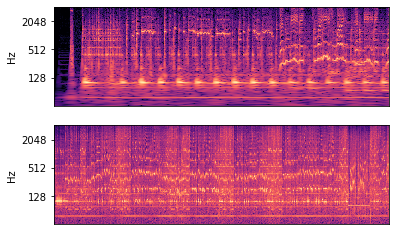

In [21]:
#PLOT
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
plt.set_cmap('viridis')

librosa.display.specshow(X["spectral_rep"]["logCQT"][6], y_axis='cqt_hz', bins_per_octave=bins_per_oct, cmap='magma', ax=ax[0])
#ax[0].title='Coldplay, Up&Up - logCQT'

librosa.display.specshow(X["reduced_spectral_rep"]["logCQT_beat"][6], y_axis='cqt_hz', bins_per_octave=bins_per_oct, cmap='magma', ax=ax[1])
#ax[1].title='Coldplay, Up&Up - Beat-synchronous logCQT'


    
plt.set_cmap('viridis')

### >> Weighted Recurrence Matrix

In [9]:
knn_no = 3
X["ssm"] = {"ssm_s_stft_beat":[], "ssm_s_logCQT_beat":[], "ssm_s_perCQT_beat":[], "ssm_s_melspec_beat":[]}
for f in range(file_no):
    for rep in ["stft_beat", "logCQT_beat", "perCQT_beat", "melspec_beat"]: 
        X["ssm"]["ssm_s_"+rep].append(librosa.segment.recurrence_matrix(X["stacked_spectral_rep"]["stacked_"+rep][f], width=knn_no, mode='affinity', sym=True))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

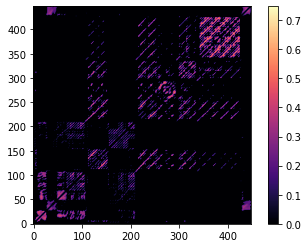

In [16]:
plt.set_cmap('magma')
plt.imshow(X["ssm"]["ssm_s_logCQT_beat"][5], origin='lower')
plt.colorbar()
plt.show()


### >> Timelag filter & Path enhancement

In [17]:
X["f_ssm"] = {"f_ssm_s_stft_beat":[], "f_ssm_s_logCQT_beat":[], "f_ssm_s_perCQT_beat":[], "f_ssm_s_melspec_beat":[]}
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)

for f in range(file_no):
    for rep in ["stft_beat", "logCQT_beat", "perCQT_beat", "melspec_beat"]: 
        X["f_ssm"]["f_ssm_s_"+rep].append(librosa.segment.path_enhance(df(X["ssm"]["ssm_s_"+rep][f], size=(1, 7)), 15))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

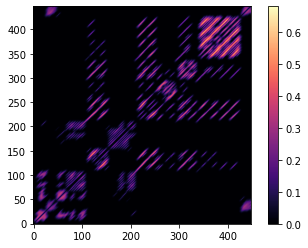

In [18]:
plt.set_cmap('magma')
plt.imshow(X["f_ssm"]["f_ssm_s_logCQT_beat"][5], origin='lower')
plt.colorbar()
plt.show()


## > Self Similarity for local connections

In [19]:
X["mfcc"]=[]
for f in range(file_no):
    X["mfcc"].append(librosa.feature.mfcc(y=X["audio"][f][0], sr=X["audio"][f][1]))

    sys.stdout.write("\rComputed %i/%s MFCCs." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed 8/8 MFCCs.

### >> Dimensionality Reduction

In [20]:
X["reduced_mfcc"]={"mfcc_beat":[]}

for f in range(file_no):
    #Beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=X["audio"][f][0], sr=X["audio"][f][1], trim=False)
    X["reduced_mfcc"]["mfcc_beat"].append(librosa.util.sync(X["mfcc"][f], beats))

    sys.stdout.write("\rDownlsampled %i/%s MFCCs." % ((f+1), str(file_no)))
    sys.stdout.flush()

Downlsampled 8/8 MFCCs.

### >> Similarity Sequence Matrix (Gaussian Kernel)

In [21]:
X["S_loc"]={"S_loc_mfcc_beat":[]}

for f in range(file_no):
    path_distance = np.sum(np.diff(X["reduced_mfcc"]["mfcc_beat"][f], axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)
    X["S_loc"]["S_loc_mfcc_beat"].append(np.diag(path_sim, k=1) + np.diag(path_sim, k=-1))

    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

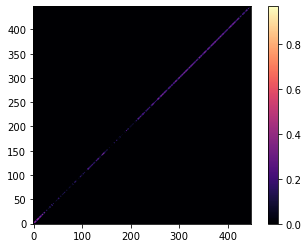

In [22]:
plt.set_cmap('magma')
plt.imshow(X["S_loc"]["S_loc_mfcc_beat"][5], origin='lower')
plt.colorbar()
plt.show()

## > Balanced Combination

In [23]:
X["A"]={"stft":[], "logCQT":[], "perCQT":[], "melspec":[]}
for rep in ["stft", "logCQT", "perCQT", "melspec"]:
    for f in range(file_no):
        S_loc = X["S_loc"]["S_loc_mfcc_beat"][f]
        S_rep = X["f_ssm"]["f_ssm_s_"+rep+"_beat"][f]
        deg_loc = np.sum(S_loc, axis=1)          
        deg_rep = np.sum(S_rep, axis=1)
        mu = deg_loc.dot(deg_loc + deg_rep) / np.sum((deg_loc + deg_rep)**2)
        A = mu * S_rep + (1 - mu) * S_loc
        X["A"][rep].append(A)
        sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
        sys.stdout.flush()

Computed for 8/8 pieces.

### >> Downsampling

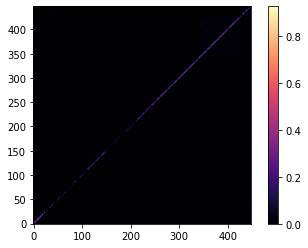

In [24]:
plt.set_cmap('magma')
plt.imshow(X["A"]["logCQT"][5], origin='lower')
plt.colorbar()
plt.show()

In [26]:
X["A_d"]={"stft":[], "logCQT":[], "perCQT":[], "melspec":[]}
for f in range(file_no):
    for rep in ["stft", "logCQT", "perCQT", "melspec"]:
        X["A_d"][rep].append(cv2.resize(X["A"][rep][f], (128,128)))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

In [27]:
X["Lsym"] = {"stft":[], "logCQT":[], "perCQT":[], "melspec":[]}
X["Lsym_d"] = {"stft":[], "logCQT":[], "perCQT":[], "melspec":[]}
for rep in ["stft", "logCQT", "perCQT", "melspec"]:
    for f in range(file_no):
        X["Lsym"][rep].append(scipy.sparse.csgraph.laplacian(X["A"][rep][f], normed=True))
        X["Lsym_d"][rep].append(scipy.sparse.csgraph.laplacian(X["A_d"][rep][f], normed=True))
        
        sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
        sys.stdout.flush()

Computed for 8/8 pieces.

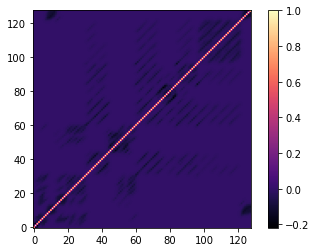

In [31]:
plt.set_cmap('magma')
plt.imshow(X["Lsym_d"]["logCQT"][5], origin='lower')
plt.colorbar()
plt.show()

## >> Eigendecomposition

In [17]:
X["D"] = {"stft":[], "logCQT":[], "perCQT":[], "melspec":[]}
X["D_d"] = {"stft":[], "logCQT":[], "perCQT":[], "melspec":[]}

for f in range(file_no):
    for rep in ["stft", "logCQT", "perCQT", "melspec"]:
        #eigendecomposition
        evals, evecs = scipy.linalg.eigh(X["Lsym"][rep][f])
        #eigenvector filtering
        evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
        #normalization
        Cnorm = np.cumsum(evecs**2, axis=1)**0.5
        k = 10 #Change component number here
        Xs = evecs[:, :k] / Cnorm[:, k-1:k]
        #distance vector to matrix
        distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
        X["D"][rep].append(distance)

        #eigendecomposition
        evals, evecs = scipy.linalg.eigh(X["Lsym_d"][rep][f])
        #eigenvector filtering
        evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
        #normalization
        Cnorm = np.cumsum(evecs**2, axis=1)**0.5
        k = 10 #Change component number here
        Xs = evecs[:, :k] / Cnorm[:, k-1:k]
        #distance vector to matrix
        distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
        X["D_d"][rep].append(distance)

In [54]:
X['graph'] = []
X['graph_d'] = []
#eigendecomposition
evals, evecs = scipy.linalg.eigh(X["Lsym"]['logCQT'][5])
#eigenvector filtering
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
#normalization
Cnorm = np.cumsum(evecs**2, axis=1)**0.5
for k in range(2, 10):
    Xs = evecs[:, :k] / Cnorm[:, k-1:k]
    distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
    X['graph'].append(distance)

#eigendecomposition
evals, evecs = scipy.linalg.eigh(X["Lsym_d"]['logCQT'][5])
#eigenvector filtering
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
#normalization
Cnorm = np.cumsum(evecs**2, axis=1)**0.5
for k in range(2, 10):
    Xs = evecs[:, :k] / Cnorm[:, k-1:k]
    distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
    X['graph_d'].append(distance)

In [55]:
normal = np.asarray(X['graph'])
downsampled = np.asarray(X['graph_d'])
fig, axs = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    axs[i].imshow(normal[i], origin='lower')
plt.show()

IndexError: index 7 is out of bounds for axis 0 with size 7

## >> Plotting eigenvector distances

<Figure size 432x288 with 0 Axes>

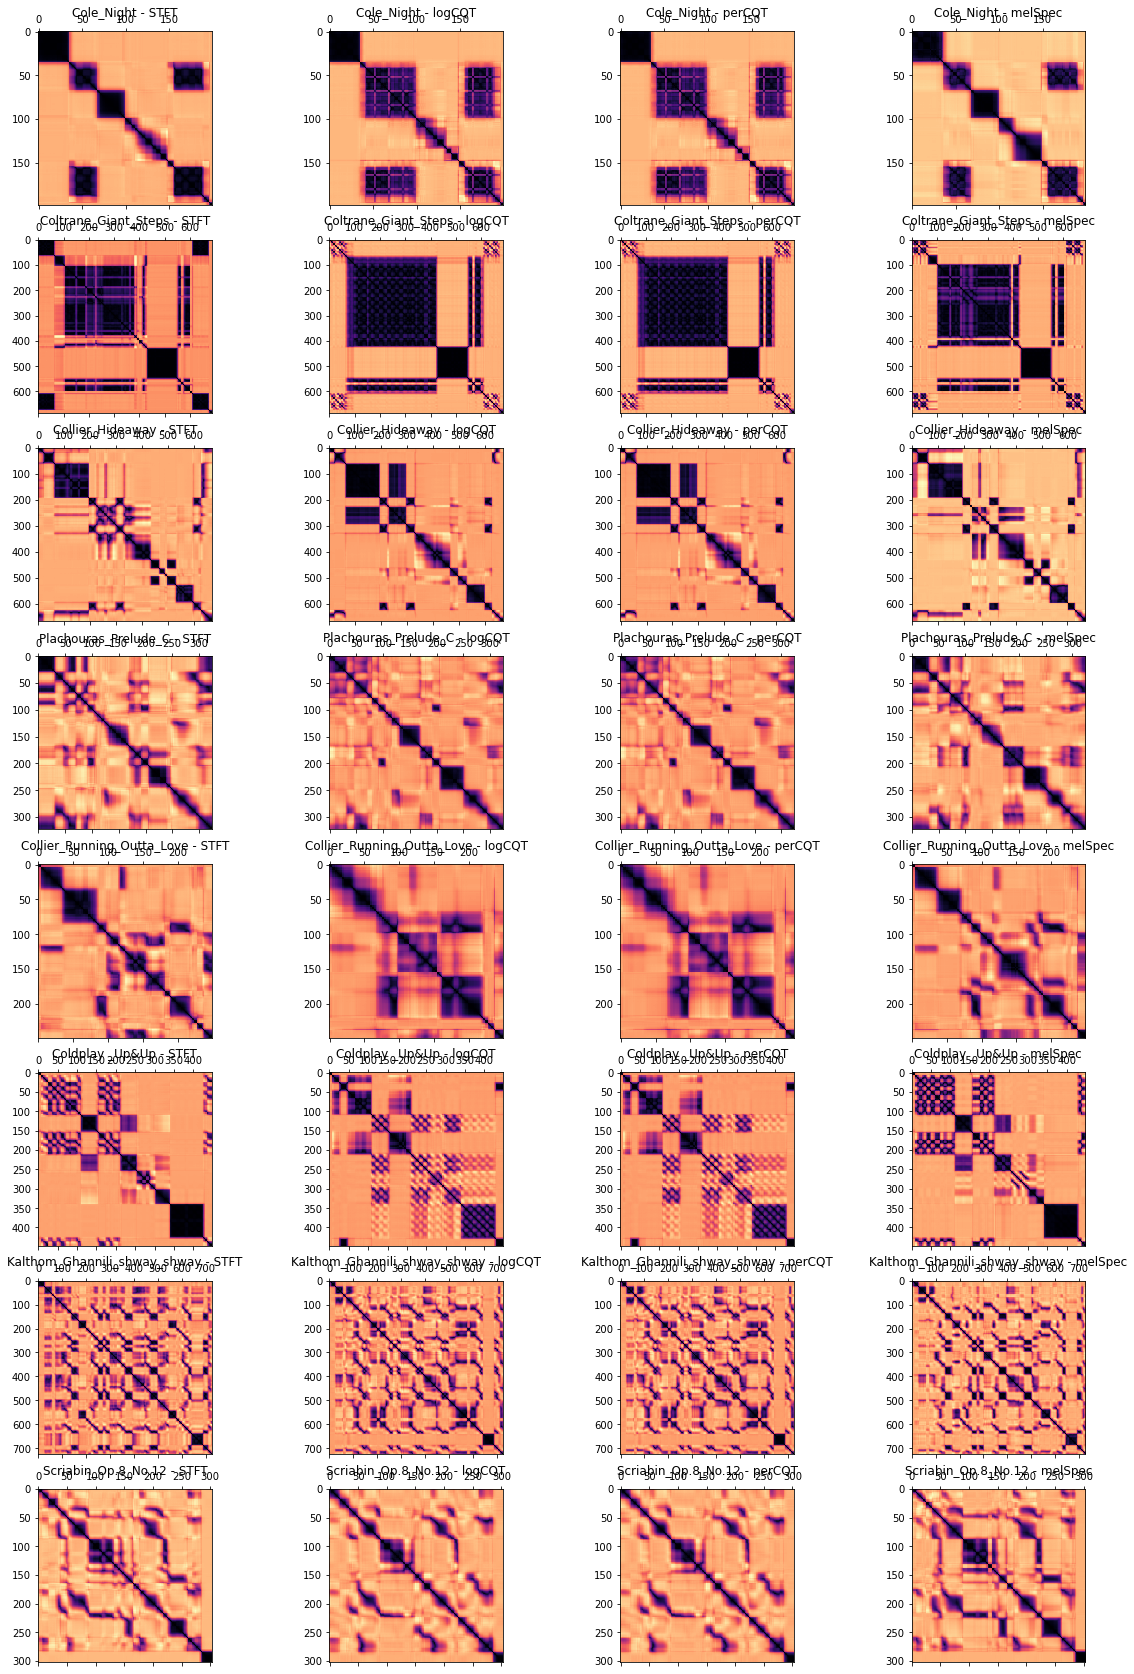

In [19]:
#Plotting original
plt.set_cmap('viridis')
fig, ax = plt.subplots(nrows=file_no, ncols=4, figsize=(20,30))
for i in range(file_no):
    ax[i,0].matshow(X["D"]["stft"][i], cmap='magma')
    ax[i, 0].set(title=all_names[i] + ' - STFT')
    ax[i,1].matshow(X["D"]["logCQT"][i], cmap='magma')
    ax[i, 1].set(title=all_names[i] + ' - logCQT')
    ax[i,2].matshow(X["D"]["perCQT"][i], cmap='magma')
    ax[i, 2].set(title=all_names[i] + ' - perCQT')
    ax[i,3].matshow(X["D"]["melspec"][i], cmap='magma')
    ax[i, 3].set(title=all_names[i] + ' - melSpec')

<Figure size 432x288 with 0 Axes>

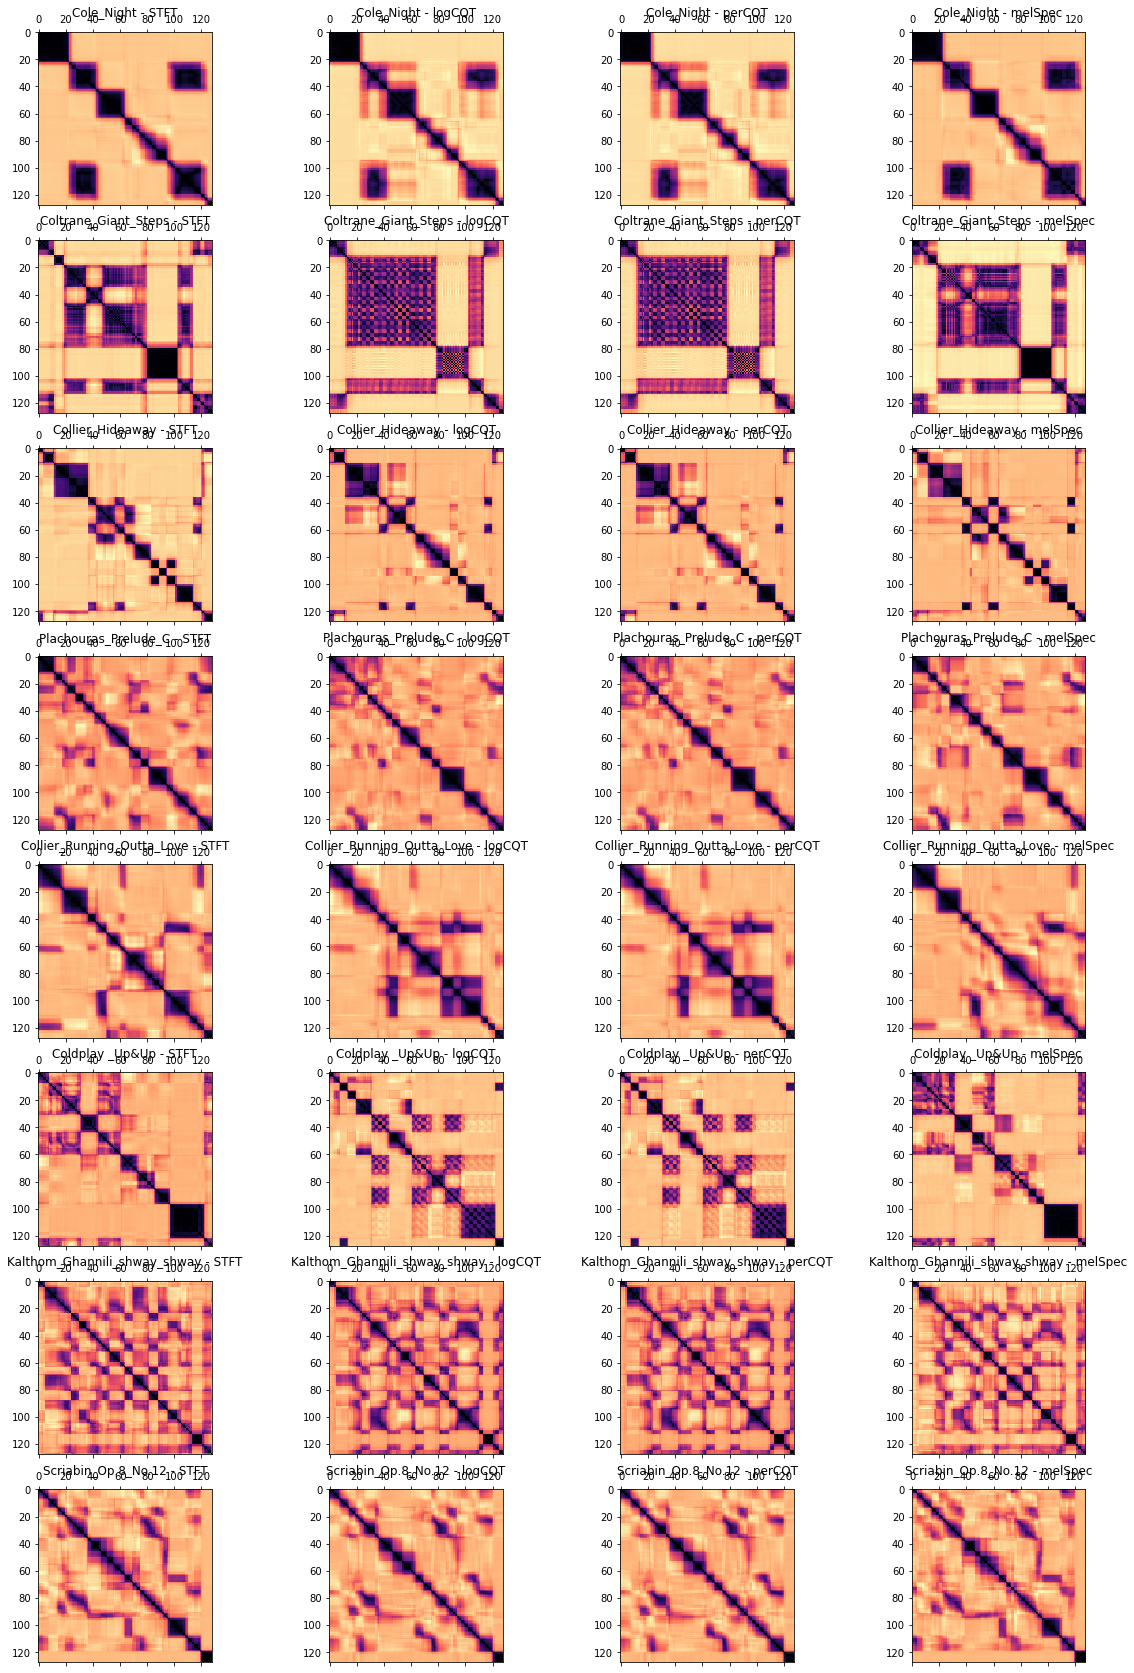

In [20]:
#Plotting from downsampled combined matrices
plt.set_cmap('viridis')
fig, ax = plt.subplots(nrows=file_no, ncols=4, figsize=(20,30))
for i in range(file_no):
    ax[i,0].matshow(X["D_d"]["stft"][i], cmap='magma')
    ax[i, 0].set(title=all_names[i] + ' - STFT')
    ax[i,1].matshow(X["D_d"]["logCQT"][i], cmap='magma')
    ax[i, 1].set(title=all_names[i] + ' - logCQT')
    ax[i,2].matshow(X["D_d"]["perCQT"][i], cmap='magma')
    ax[i, 2].set(title=all_names[i] + ' - perCQT')
    ax[i,3].matshow(X["D_d"]["melspec"][i], cmap='magma')
    ax[i, 3].set(title=all_names[i] + ' - melSpec')